In [1]:
import h2o
import operator
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
from matplotlib import pyplot as plt
import warnings
import sys
sys.path.append('../plot/')
from ice import ice, ice_plot
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
warnings.filterwarnings("ignore")
from h2o.estimators.random_forest import H2ORandomForestEstimator
from IPython.display import Image, display
from h2o.backend import H2OLocalServer
import subprocess
%matplotlib inline

# 1 Data Preparation

## 1.1 H2O Initialization

In [2]:
pct_memory=4
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

17


In [3]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,5 hours 15 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,9 days
H2O cluster name:,H2O_from_python_mandy_jpex0n
H2O cluster total nodes:,1
H2O cluster free memory:,26.88 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


## 1.2 Data Import & Parse

In [4]:
data_path = "../data/yelp.csv"

# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
reviews.shape

(10086, 10)

In [6]:
reviews.head(3)

business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,"My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better. Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I've ever had. I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing. While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best ""toast"" I've ever had. Anyway, I can't wait to go back!",review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
ZRJwVLyzEJq1VAihDhYiow,2011-07-27 00:00:00,IjZ33sJrzXqU-0X6U8NwyA,5,"I have no idea why some people give bad reviews about this place. It goes to show you, you can please everyone. They are probably griping about something that their own fault...there are many people like that. In any case, my friend and I arrived at about 5:50 PM this past Sunday. It was pretty crowded, more than I thought for a Sunday evening and thought we would have to wait forever to get a seat but they said we'll be seated when the girl comes back from seating someone else. We were seated at 5:52 and the waiter came and got our drink orders. Everyone was very pleasant from the host that seated us to the waiter to the server. The prices were very good as well. We placed our orders once we decided what we wanted at 6:02. We shared the baked spaghetti calzone and the small ""Here's The Beef"" pizza so we can both try them. The calzone was huge and we got the smallest one (personal) and got the small 11"" pizza. Both were awesome! My friend liked the pizza better and I liked the calzone better. The calzone does have a sweetish sauce but that's how I like my sauce! We had to box part of the pizza to take it home and we were out the door by 6:42. So, everything was great and not like these bad reviewers. That goes to show you that you have to try these things yourself because all these bad reviewers have some serious issues.",review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
6oRAC4uyJCsJl1X0WZpVSA,2012-06-14 00:00:00,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I also dig their candy selection :),review,0hT2KtfLiobPvh6cDC8JQg,0,1,0


In [7]:
reviews['PositiveReview']=(reviews['stars']>=reviews['stars'].mean()[0]).ifelse('1','0')

In [8]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,3222
1,6864


In [9]:
cols_df = h2o.H2OFrame.from_python(np.transpose(list(range(1, 10087))), column_names=list(['Id']))
cols_df.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(10086, 1)

In [10]:
reviews = cols_df.cbind(reviews)
reviews.head(3)

Id,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,PositiveReview
1,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,"My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better. Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I've ever had. I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing. While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best ""toast"" I've ever had. Anyway, I can't wait to go back!",review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,1
2,ZRJwVLyzEJq1VAihDhYiow,2011-07-27 00:00:00,IjZ33sJrzXqU-0X6U8NwyA,5,"I have no idea why some people give bad reviews about this place. It goes to show you, you can please everyone. They are probably griping about something that their own fault...there are many people like that. In any case, my friend and I arrived at about 5:50 PM this past Sunday. It was pretty crowded, more than I thought for a Sunday evening and thought we would have to wait forever to get a seat but they said we'll be seated when the girl comes back from seating someone else. We were seated at 5:52 and the waiter came and got our drink orders. Everyone was very pleasant from the host that seated us to the waiter to the server. The prices were very good as well. We placed our orders once we decided what we wanted at 6:02. We shared the baked spaghetti calzone and the small ""Here's The Beef"" pizza so we can both try them. The calzone was huge and we got the smallest one (personal) and got the small 11"" pizza. Both were awesome! My friend liked the pizza better and I liked the calzone better. The calzone does have a sweetish sauce but that's how I like my sauce! We had to box part of the pizza to take it home and we were out the door by 6:42. So, everything was great and not like these bad reviewers. That goes to show you that you have to try these things yourself because all these bad reviewers have some serious issues.",review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1
3,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14 00:00:00,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I also dig their candy selection :),review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,1


In [11]:
split = reviews["Id"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Id"] < split).ifelse("Yes", "No")

In [12]:
reviews['Train'].table()

Train,Count
No,2018
Yes,8068


In [13]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

In [14]:
train.head()

Id,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,PositiveReview,Train
1,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,"My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better. Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I've ever had. I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing. While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best ""toast"" I've ever had. Anyway, I can't wait to go back!",review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,1,Yes
2,ZRJwVLyzEJq1VAihDhYiow,2011-07-27 00:00:00,IjZ33sJrzXqU-0X6U8NwyA,5,"I have no idea why some people give bad reviews about this place. It goes to show you, you can please everyone. They are probably griping about something that their own fault...there are many people like that. In any case, my friend and I arrived at about 5:50 PM this past Sunday. It was pretty crowded, more than I thought for a Sunday evening and thought we would have to wait forever to get a seat but they said we'll be seated when the girl comes back from seating someone else. We were seated at 5:52 and the waiter came and got our drink orders. Everyone was very pleasant from the host that seated us to the waiter to the server. The prices were very good as well. We placed our orders once we decided what we wanted at 6:02. We shared the baked spaghetti calzone and the small ""Here's The Beef"" pizza so we can both try them. The calzone was huge and we got the smallest one (personal) and got the small 11"" pizza. Both were awesome! My friend liked the pizza better and I liked the calzone better. The calzone does have a sweetish sauce but that's how I like my sauce! We had to box part of the pizza to take it home and we were out the door by 6:42. So, everything was great and not like these bad reviewers. That goes to show you that you have to try these things yourself because all these bad reviewers have some serious issues.",review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1,Yes
3,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14 00:00:00,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I also dig their candy selection :),review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,1,Yes
4,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27 00:00:00,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!! It's very convenient and surrounded by a lot of paths, a desert xeriscape, baseball fields, ballparks, and a lake with ducks. The Scottsdale Park and Rec Dept. does a wonderful job of keeping the park clean and shaded. You can find trash cans and poopy-pick up mitts located all over the park and paths. The fenced in area is huge to let the dogs run, play, and sniff!",review,uZetl9T0NcROGOyFfughhg,1,2,0,1,Yes
5,6ozycU1RpktNG2-1BroVtw,2012-01-05 00:00:00,1uJFq2r5QfJG_6ExMRCaGw,5,"General Manager Scott Petello is a good egg!!! Not to go into detail, but let me assure you if you have any issues (albeit rare) speak with Scott and treat the guy with some respect as you state your case and I'd be surprised if you don't walk out totally satisfied as I just did. Like I always say..... ""Mistakes are inevitable, it's how we recover from them that is important""!!! Thanks to Scott and his awesome staff. You've got a customer for life!! .......... :^)",review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,1,Yes
6,-yxfBYGB6SEqszmxJxd97A,2007-12-13 00:00:00,m2CKSsepBCoRYWxiRUsxAg,4,"Quiessence is, simply put, beautiful. Full windows and earthy wooden walls g

## 1.3 Tokenize Words in Review

In [15]:
data_path = "../data/stopwords.csv"
STOP_WORDS = pd.read_csv(data_path, header=0)

In [16]:
STOP_WORDS.head()

,STOP_WORD
0,all
1,just
2,being
3,over
4,both


In [17]:
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [18]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [19]:
# Break reviews into sequence of words
words = tokenize(reviews["text"])

In [20]:
words.head()

C1
wife
took
birthday
breakfast
excellent
weather
perfect
made
sitting
outside


## 1.4 Word2Vec Model

In [21]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

models_path='../data'
h2o.save_model(w2v_model, path = models_path, force = True)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


'/Users/mandy/Desktop/AI-Addin/data/w2v.hex'

In [22]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("awesome", count = 5)

OrderedDict([('amazing', 0.7305544018745422),
             ('great', 0.7073903679847717),
             ('fantastic', 0.6555815935134888),
             ('good', 0.5999718308448792),
             ('love', 0.5915692448616028)])

In [23]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("boring", count = 5)

OrderedDict([('lacking', 0.6481058597564697),
             ('strangely', 0.6266922950744629),
             ('rotting', 0.5957953333854675),
             ('fresher', 0.5897741317749023),
             ('crumbly', 0.5868799090385437)])

In [24]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.0431898,0.00819708,-0.127153,-0.112452,-0.0631461,-0.0435626,0.0502669,0.0482737,0.0725893,0.138895,-0.218187,0.0838325,0.0552184,-0.0183307,0.110987,-0.00389015,0.0968412,0.0855157,0.00709401,-0.155693,0.134107,0.0456063,-0.0596474,0.0763334,-0.0981727,-0.114887,-0.0921806,-0.0736998,0.0983805,0.153152,-0.0353571,-0.0620659,-0.134173,0.123079,0.0573049,-0.0506106,0.0233568,0.104748,0.0746219,0.0159259,-0.0835604,-0.056167,0.0599406,-0.188318,0.0238897,0.0227452,-0.0190722,0.0246319,0.00369343,-0.128639,-0.0416925,0.0659668,-0.0140636,0.0184442,-0.00780141,-0.0249494,-0.121143,-0.117083,0.0023749,-0.0267237,0.00822276,0.0245645,-0.0415329,-0.0995334,-0.254758,0.0433231,-0.130343,-0.0500048,0.040597,0.0915819,0.033776,-0.127447,0.0660022,-0.0230274,0.0294671,-0.0220785,0.0508434,0.0873425,-0.0878835,-0.00135121,-0.0737352,-0.0262945,-0.122483,-0.0194011,0.0418162,-0.0632937,-0.0974902,-0.0161878,0.0572028,-0.10692,-0.11871,-0.0496035,0.105676,-0.077311,0.0983732,0.0349728,-0.00113467,-0.0224675,0.17549,-0.00091791
0.00017889,-0.00720336,-0.120389,-0.0925545,-0.0577572,0.0244621,0.0116285,0.0795576,0.0153647,0.0812757,-0.204441,0.0478633,-0.0123554,-0.0425688,0.0606324,-0.0384204,-0.00817711,0.0671107,0.00808567,-0.156547,0.100079,0.0853757,-0.115265,0.041196,-0.11562,-0.0917047,-0.0757228,-0.0838364,0.183193,0.173723,0.00168545,-0.101552,-0.113226,0.0257204,-0.0151856,-0.0916757,-0.0356884,0.0511016,0.127393,-0.00380766,-0.0669983,-0.0425707,0.0508257,-0.197718,0.00536989,0.0617084,0.046265,0.0494187,-0.0297837,-0.182351,-0.0863291,-0.00952905,-0.0604534,0.0227292,0.0484366,0.0184336,-0.0898357,-0.0172932,-0.0261528,-0.0101418,0.0518519,-0.0442426,-0.0811379,-0.0403576,-0.247911,0.0379989,-0.134306,-0.0576566,-0.00829652,0.0178307,0.000270571,-0.0753186,0.0370035,-0.0824032,-0.0772768,-0.0890433,0.135975,-0.00755732,0.0192201,0.0319976,-0.169339,-0.012452,-0.0823149,-0.00834568,0.0610759,-0.00135928,-0.0396396,-0.0361413,0.0337494,-0.151135,-0.0915519,-0.0675402,0.0580742,-0.0934196,0.127513,-0.00919585,0.051046,-0.029212,0.149176,-0.0313857
0.106799,-0.0229191,-0.141101,-0.14213,0.0116885,-0.168027,0.0414774,0.0247037,0.176357,0.104611,-0.132004,0.118546,0.0742827,-0.0280291,0.107955,0.0285146,0.158337,0.117471,0.0672271,-0.0319159,0.0707075,0.00209604,-0.0865594,0.154967,-0.0936793,-0.112215,0.0205206,0.0220109,0.0499405,0.233911,0.0923438,-0.0354833,-0.0217929,0.030053,-0.0963186,0.0362421,0.0894352,0.0581718,0.15209,-0.127306,-0.0423213,-0.044552,0.212969,-0.254531,0.135731,-0.1482,0.0433305,-0.0297662,-0.0545842,-0.040827,-0.0663244,-0.139556,-0.0624151,-0.0841503,0.106131,0.0428485,-0.25913,-0.0216093,-0.0833018,-0.124735,-0.0344872,0.0599681,-0.0650236,-0.179834,-0.251437,0.0499608,-0.0875035,-0.0313834,0.13659,0.06815,-0.00825899,-0.176989,-0.0187387,-0.0960339,-0.0215186,0.0603519,0.07431,0.0146937,-0.00427676,0.0468974,0.105265,-0.0218014,-0.0186733,-0.0136735,0.0561323,-0.0631116,-0.185539,-0.119507,0.0898278,-0.210977,-0.122169,-0.16925,-0.157575,-0.10246,0.0645169,0.0173412,0.159447,0.0624964,0.243851,0.0242383
0.153659,-0.00604791,0.0200996,-0.0286708,-0.0836917,-0.0182456,0.0845177,0.0222955,0.0469392,0.0348905,-0.214994,0.135255,0.0303053,-0.0598665,0.0107332,-0.012509,-0.0447251,0.0403478,-0.0957654,-0.00865626,0.0513762,-0.0570259,0.0691615,-0.0112706,-0.179633,0.0168146,-0.0787937,-0.0935882,0.00464708,0.0444036,-0.0377064,-0.246995,-0.0958932,0.103099,0.0299523,0.0363824,0.188732,0.0928111,0.0893646,-0.100941,-0.320099,0.0317776,0.124988,-0.0412817,0.0780821,-0.0460345,0.202563,0.127195,0.0477958,-0.0483759,-0.0217838,-0.

In [25]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

In [26]:
ext_reviews = ext_reviews.drop([1, 5])

In [27]:
ext_reviews.head(3)

Id,date,review_id,stars,type,user_id,cool,useful,funny,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
1,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,1,Yes,0.0431898,0.00819708,-0.127153,-0.112452,-0.0631461,-0.0435626,0.0502669,0.0482737,0.0725893,0.138895,-0.218187,0.0838325,0.0552184,-0.0183307,0.110987,-0.00389015,0.0968412,0.0855157,0.00709401,-0.155693,0.134107,0.0456063,-0.0596474,0.0763334,-0.0981727,-0.114887,-0.0921806,-0.0736998,0.0983805,0.153152,-0.0353571,-0.0620659,-0.134173,0.123079,0.0573049,-0.0506106,0.0233568,0.104748,0.0746219,0.0159259,-0.0835604,-0.056167,0.0599406,-0.188318,0.0238897,0.0227452,-0.0190722,0.0246319,0.00369343,-0.128639,-0.0416925,0.0659668,-0.0140636,0.0184442,-0.00780141,-0.0249494,-0.121143,-0.117083,0.0023749,-0.0267237,0.00822276,0.0245645,-0.0415329,-0.0995334,-0.254758,0.0433231,-0.130343,-0.0500048,0.040597,0.0915819,0.033776,-0.127447,0.0660022,-0.0230274,0.0294671,-0.0220785,0.0508434,0.0873425,-0.0878835,-0.00135121,-0.0737352,-0.0262945,-0.122483,-0.0194011,0.0418162,-0.0632937,-0.0974902,-0.0161878,0.0572028,-0.10692,-0.11871,-0.0496035,0.105676,-0.077311,0.0983732,0.0349728,-0.00113467,-0.0224675,0.17549,-0.00091791
2,2011-07-27 00:00:00,IjZ33sJrzXqU-0X6U8NwyA,5,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1,Yes,0.00017889,-0.00720336,-0.120389,-0.0925545,-0.0577572,0.0244621,0.0116285,0.0795576,0.0153647,0.0812757,-0.204441,0.0478633,-0.0123554,-0.0425688,0.0606324,-0.0384204,-0.00817711,0.0671107,0.00808567,-0.156547,0.100079,0.0853757,-0.115265,0.041196,-0.11562,-0.0917047,-0.0757228,-0.0838364,0.183193,0.173723,0.00168545,-0.101552,-0.113226,0.0257204,-0.0151856,-0.0916757,-0.0356884,0.0511016,0.127393,-0.00380766,-0.0669983,-0.0425707,0.0508257,-0.197718,0.00536989,0.0617084,0.046265,0.0494187,-0.0297837,-0.182351,-0.0863291,-0.00952905,-0.0604534,0.0227292,0.0484366,0.0184336,-0.0898357,-0.0172932,-0.0261528,-0.0101418,0.0518519,-0.0442426,-0.0811379,-0.0403576,-0.247911,0.0379989,-0.134306,-0.0576566,-0.00829652,0.0178307,0.000270571,-0.0753186,0.0370035,-0.0824032,-0.0772768,-0.0890433,0.135975,-0.00755732,0.0192201,0.0319976,-0.169339,-0.012452,-0.0823149,-0.00834568,0.0610759,-0.00135928,-0.0396396,-0.0361413,0.0337494,-0.151135,-0.0915519,-0.0675402,0.0580742,-0.0934196,0.127513,-0.00919585,0.051046,-0.029212,0.149176,-0.0313857
3,2012-06-14 00:00:00,IESLBzqUCLdSzSqm0eCSxQ,4,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,1,Yes,0.106799,-0.0229191,-0.141101,-0.14213,0.0116885,-0.168027,0.0414774,0.0247037,0.176357,0.104611,-0.132004,0.118546,0.0742827,-0.0280291,0.107955,0.0285146,0.158337,0.117471,0.0672271,-0.0319159,0.0707075,0.00209604,-0.0865594,0.154967,-0.0936793,-0.112215,0.0205206,0.0220109,0.0499405,0.233911,0.0923438,-0.0354833,-0.0217929,0.030053,-0.0963186,0.0362421,0.0894352,0.0581718,0.15209,-0.127306,-0.0423213,-0.044552,0.212969,-0.254531,0.135731,-0.1482,0.0433305,-0.0297662,-0.0545842,-0.040827,-0.0663244,-0.139556,-0.0624151,-0.0841503,0.106131,0.0428485,-0.25913,-0.0216093,-0.0833018,-0.124735,-0.0344872,0.0599681,-0.0650236,-0.179834,-0.251437,0.0499608,-0.0875035,-0.0313834,0.13659,0.06815,-0.00825899,-0.176989,-0.0187387,-0.0960339,-0.0215186,0.0603519,0.07431,0.0146937,-0.00427676,0.0468974,0.105265,-0.0218014,-0.0186733,-0.0136735,0.0561323,-0.0631116,-0.185539,-0.119507,0.0898278,-0.210977,-0.122169,-0.16925,-0.157575,-0.10246,0.0645169,0.0173412,0.159447,0.0624964,0.243851,0.0242383


In [28]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]

In [29]:
predictors = ['date','review_id','user_id','cool','useful','funny'] + review_vecs.names
response = 'PositiveReview'

## 1.5 Leaderboard

In [90]:
aml = H2OAutoML()

In [92]:
aml.train(x=predictors,y=response,training_frame=ext_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [93]:
print(aml.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190426_140523,0.846889,0.436274,0.275104,0.374472,0.140229
GLM_grid_1_AutoML_20190426_140523_model_1,0.84419,0.44428,0.271968,0.376596,0.141824
XGBoost_grid_1_AutoML_20190426_140523_model_8,0.843375,0.440441,0.260929,0.377569,0.142559
DeepLearning_grid_1_AutoML_20190426_140523_model_1,0.841085,0.466155,0.280023,0.382047,0.14596
XGBoost_2_AutoML_20190426_140523,0.840194,0.448026,0.32472,0.380326,0.144648
XGBoost_grid_1_AutoML_20190426_140523_model_10,0.839452,0.450697,0.317931,0.380994,0.145157
XGBoost_grid_1_AutoML_20190426_140523_model_3,0.83757,0.455414,0.298487,0.383773,0.147282
XGBoost_3_AutoML_20190426_140523,0.837124,0.45012,0.307592,0.381667,0.14567
GBM_5_AutoML_20190426_140523,0.836641,0.452982,0.327585,0.383299,0.146918
XGBoost_grid_1_AutoML_20190426_140523_model_2,0.836577,0.455647,0.303127,0.383852,0.147342


# 2 Training Models

## 2.1 Generalized Linear Model

### 2.1.1 Train & Fit Model

In [71]:
# Initialize
local_glm_plus = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_surrogate', lambda_search=True)
# train 
local_glm_plus.train(x=predictors, y=response, training_frame=ext_train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.1.2 Interpretability

#### Variable Importance

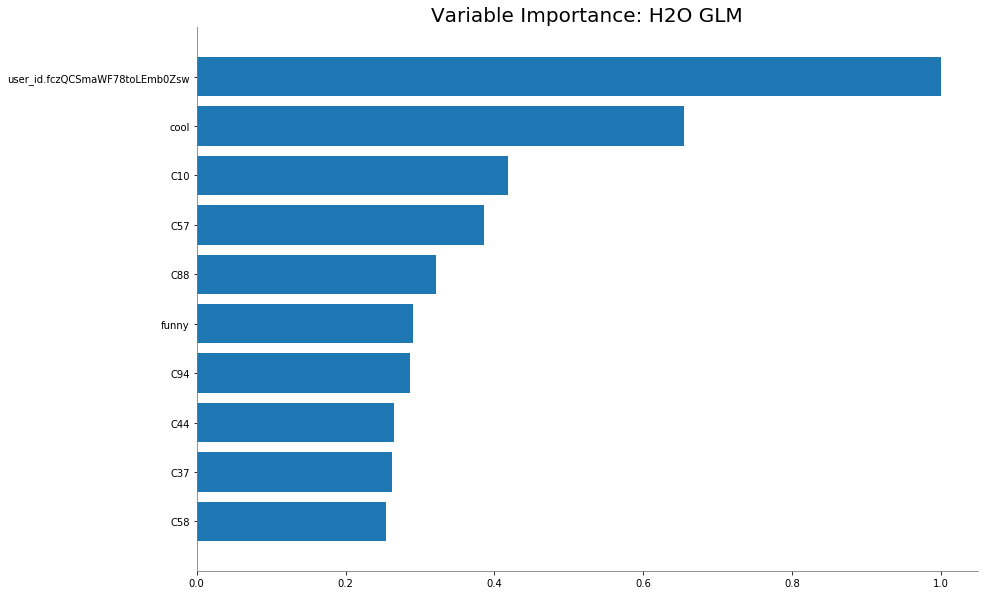

In [72]:
local_glm_plus.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


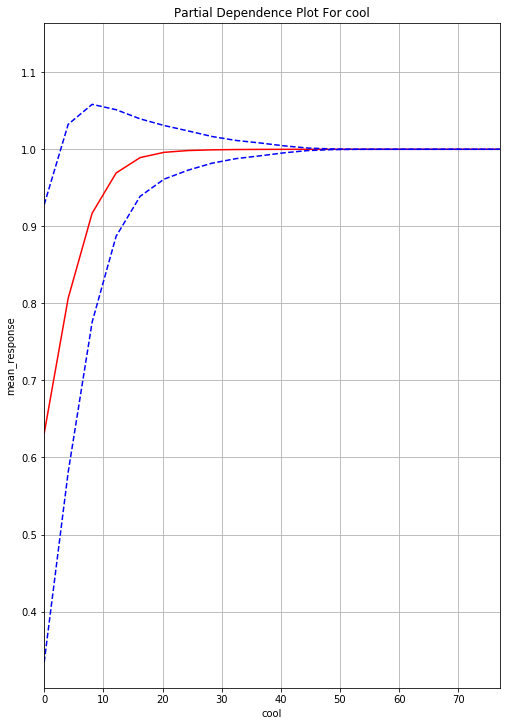

In [81]:
pdp_local_linear_plus = local_glm_plus.partial_plot(data = ext_train, cols = ["cool"])

#### Individual Conditional Expectation (ICE)

In [39]:
cool_ice_df = ice(data=ext_test, column='cool', model=local_glm_plus)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


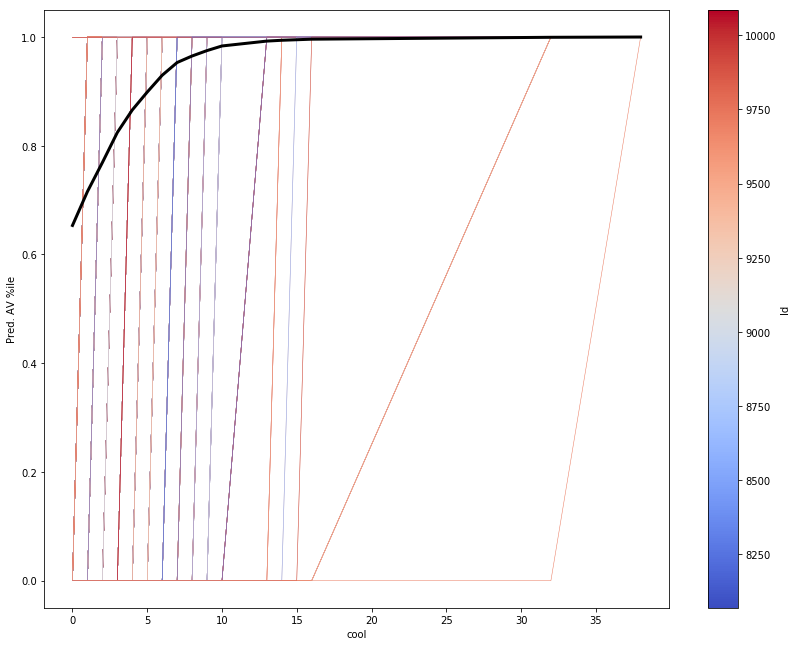

In [40]:
ice_plot(cool_ice_df, linewidth=0.5, color_by='Id', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = cool_ice_df.columns.get_level_values('Id').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Id')
plt.ylabel('Pred. AV %ile')
plt.xlabel('cool');

### 2.1.3 Matrix

In [41]:
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm_plus.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))


Local GLM Coefficients:
C79:                      -5.018925505102411
C57:                      -4.644016082846337
C41:                      -3.878943522779333
C60:                      -3.5380527217071758
C8:                       -3.5320296316417052
C56:                      -3.5291116491948458
C63:                      -2.795024660672351
C45:                      -2.5072228961521676
C77:                      -2.4424988538820256
C64:                      -2.350217340582202
C18:                      -2.1559747144246257
C71:                      -2.0820763289959894
C31:                      -2.070175151884911
C5:                       -1.9937596154786532
C73:                      -1.9482301970044602
C39:                      -1.8800649674481873
C94:                      -1.869277240029466
C14:                      -1.7688666222541425
C100:                     -1.7632479917523838
C28:                      -1.5875909568990183
C88:                      -1.5156756235278732
C69:            

In [42]:
local_glm_plus.r2(train=True, valid=True)

{'train': 0.3984611909068989, 'valid': None}

In [43]:
local_glm_plus.auc()

0.8728432206966407

In [44]:
local_glm_plus.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5361433357375776: 


,0,1,Error,Rate
0,1762.0,838.0,0.3223,(838.0/2600.0)
1,635.0,4833.0,0.1161,(635.0/5468.0)
Total,2397.0,5671.0,0.1826,(1473.0/8068.0)


## 2.2 Logistic Regression

### 2.2.1 Train & Fit Model

In [79]:
glm_logistic_plus_summary = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic_plus_summary.train(x=predictors, 
                               y= response, 
                               training_frame = ext_train, 
                               validation_frame = ext_test, 
                               model_id="glm_logistic")

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.2.2 Interpretability

#### Variable Importance

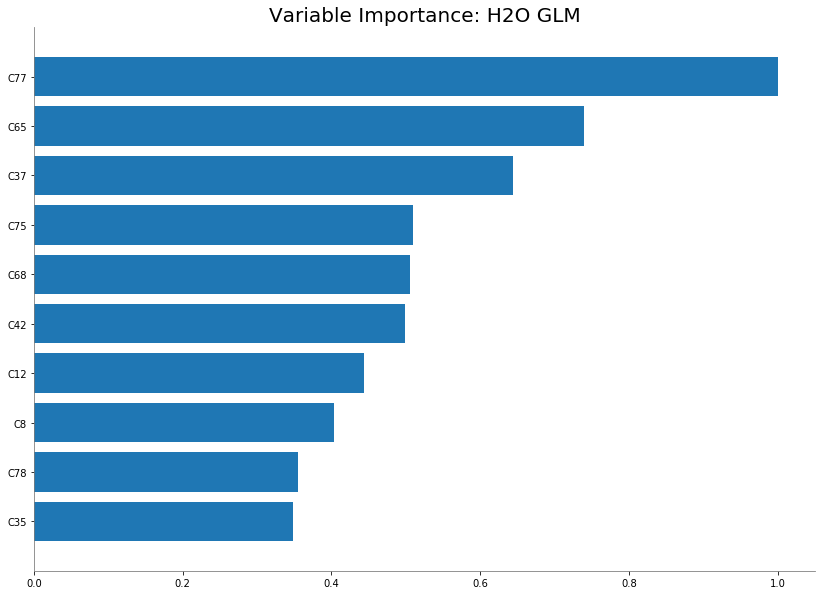

In [80]:
glm_logistic_plus_summary.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


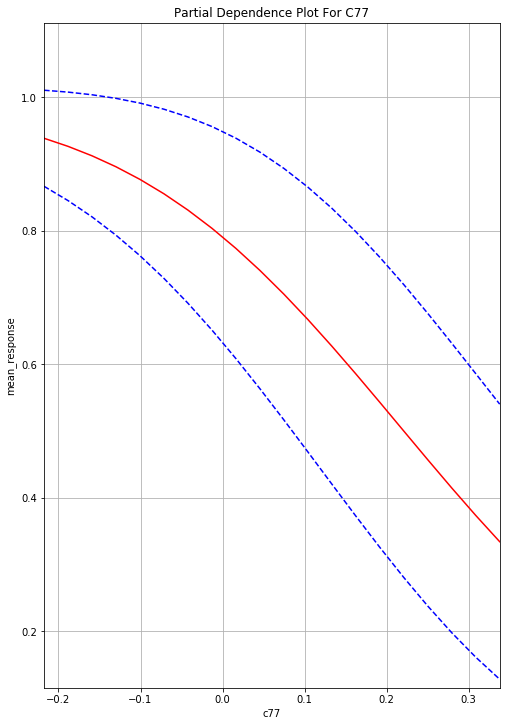

In [81]:
pdp_word_vecs = glm_logistic_plus_summary.partial_plot(data = ext_train, cols = ["C77"])

#### Individual Conditional Expectation (ICE)

In [85]:
ext_train_lice = h2o.H2OFrame(ext_train.as_data_frame().iloc[::25])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [87]:
C77_ice_df = ice(data=ext_train_lice, column='C77', model=glm_logistic_plus_summary)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


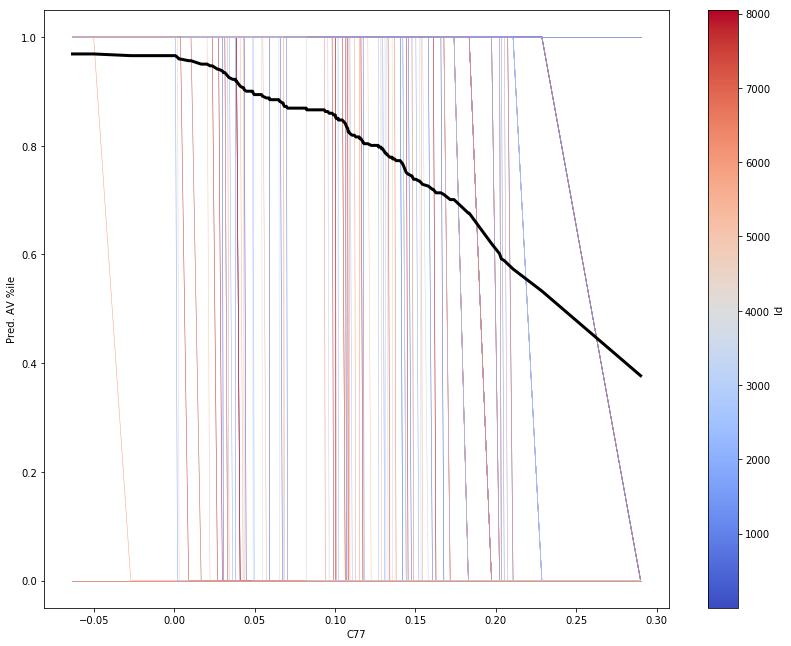

In [88]:
ice_plot(C77_ice_df, linewidth=0.5, color_by='Id', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C77_ice_df.columns.get_level_values('Id').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Id')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C77');

### 2.2.3 Matrix

In [44]:
print("With Summary and Review Embeddings AUC: " + str(round(glm_logistic_plus_summary.auc(valid = True), 3)))

With Summary and Review Embeddings AUC: 0.842


In [45]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5070642821523546: 


,0,1,Error,Rate
0,336.0,286.0,0.4598,(286.0/622.0)
1,121.0,1275.0,0.0867,(121.0/1396.0)
Total,457.0,1561.0,0.2017,(407.0/2018.0)


In [46]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5070642821523546: 


,0,1,Error,Rate
0,336.0,286.0,0.4598,(286.0/622.0)
1,121.0,1275.0,0.0867,(121.0/1396.0)
Total,457.0,1561.0,0.2017,(407.0/2018.0)


## 2.3 Decision Tree

### 2.3.1 Train & Fit Model

In [35]:
# initialize single tree surrogate model
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=predictors, y=response, training_frame=ext_train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [36]:
# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='data')

print(surrogate)
print('Generated MOJO path:\n', mojo_path)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.21089871882753441
RMSE: 0.4592371052381704
LogLoss: 0.6115536861708426
Mean Per-Class Error: 0.3109642113555793
AUC: 0.7449350416408755
pr_auc: 0.6030539354482377
Gini: 0.4898700832817511
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6581554587218695: 


,0,1,Error,Rate
0,637.0,1963.0,0.755,(1963.0/2600.0)
1,227.0,5241.0,0.0415,(227.0/5468.0)
Total,864.0,7204.0,0.2714,(2190.0/8068.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6581555,0.8271780,6.0
max f2,0.6349211,0.9131597,7.0
max f0point5,0.6828912,0.7990986,3.0
max accuracy,0.6599247,0.7293009,5.0
max precision,0.7008214,0.9132075,0.0
max recall,0.6349211,1.0,7.0
max specificity,0.7008214,0.9469231,0.0
max absolute_mcc,0.6828912,0.3755650,3.0
max min_per_class_accuracy,0.6828912,0.5869231,3.0
max mean_per_class_accuracy,0.6828912,0.6890358,3.0


Gains/Lift Table: Avg response rate: 67.77 %, avg score: 67.74 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.1970749,0.7008214,1.3474321,1.3474321,0.9132075,0.7008214,0.9132075,0.7008214,0.2655450,0.2655450,34.7432058,34.7432058
,2,0.3365146,0.6898417,1.1803950,1.2782178,0.8,0.6898417,0.8662983,0.6962718,0.1645940,0.4301390,18.0395026,27.8217818
,3,0.4292266,0.6849224,1.1066203,1.2411532,0.75,0.6849224,0.8411782,0.6938204,0.1025969,0.5327359,10.6620337,24.1153158
,4,0.6693109,0.6828912,1.0763411,1.1820345,0.7294786,0.6828912,0.8011111,0.6899000,0.2584126,0.7911485,7.6341102,18.2034463
,5,0.7471492,0.6620022,0.7706401,1.1391752,0.5222930,0.6620022,0.7720637,0.6869936,0.0599854,0.8511339,-22.9359936,13.9175193
,6,0.8683689,0.6599247,0.7407643,1.0835592,0.5020450,0.6599247,0.7343705,0.6832149,0.0897952,0.9409290,-25.9235739,8.3559165
,7,1.0,0.6349211,0.4487613,1.0,0.3041431,0.6392529,0.6777392,0.6774282,0.0590710,1.0,-55.1238708,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-26 17:55:24,0.080 sec,0.0,0.4673422,0.6285618,0.5,0.0,1.0,0.3222608
,2019-04-26 17:55:24,0.159 sec,1.0,0.4592371,0.6115537,0.7449350,0.6030539,1.3474321,0.2714427


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C77,139.3017273,1.0,0.4413810
C37,98.7354431,0.7087884,0.3128457
C68,35.5079460,0.2548995,0.1125078
C42,33.6154633,0.2413140,0.1065114
C75,8.4436569,0.0606142,0.0267539
---,---,---,---
C96,0.0,0.0,0.0
C97,0.0,0.0,0.0
C98,0.0,0.0,0.0
C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()

Generated MOJO path:
 /Users/mandy/Desktop/AI-Addin/notebook/data


In [37]:
details = False # print more info on tree, details = True
title = 'Yelp Reviews Decision Tree Surrogate'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o ').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/mandy/Desktop/AI-Addin/notebook/data -o dt_surrogate_mojo.gv --title Yelp Reviews Decision Tree Surrogate


In [38]:
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

print('Calling external process ...')
print(' '.join(png_args))

_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


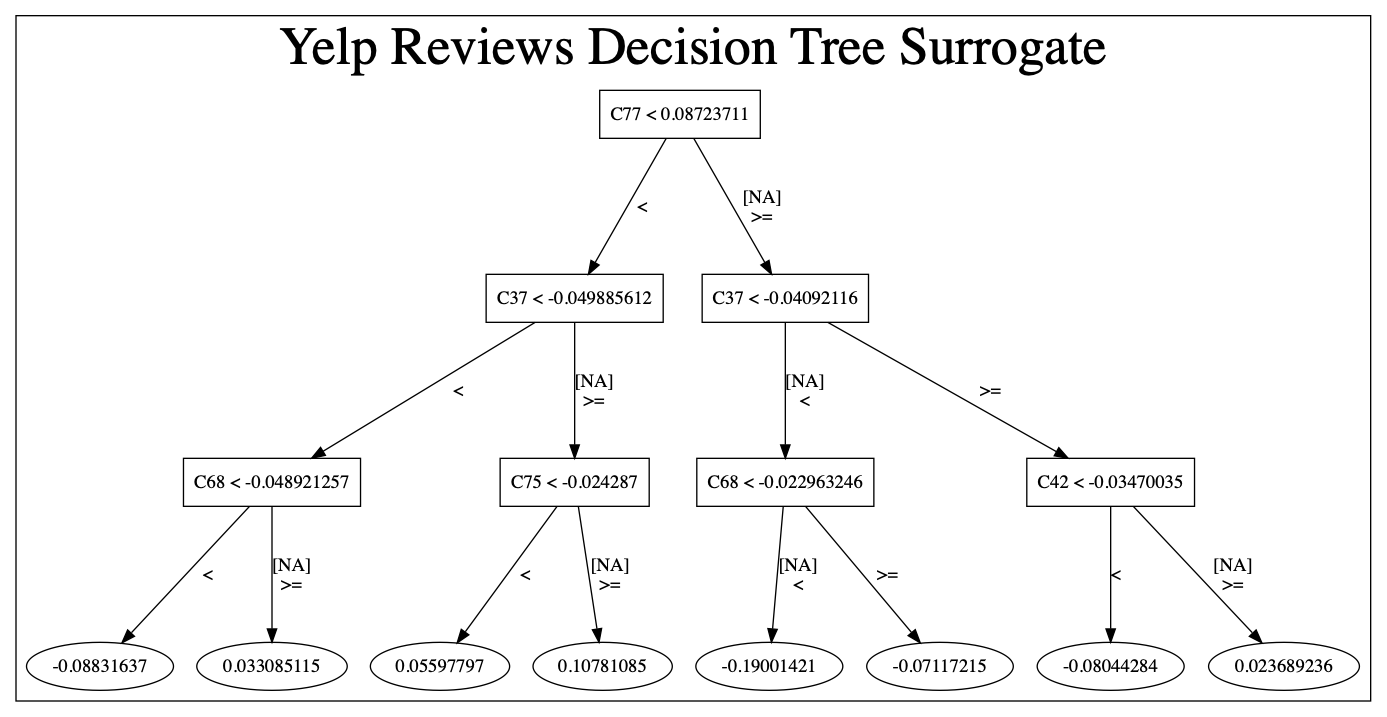

In [39]:
display(Image((png_file_name)))

### 2.3.2 Interpretability

#### Variable Importance

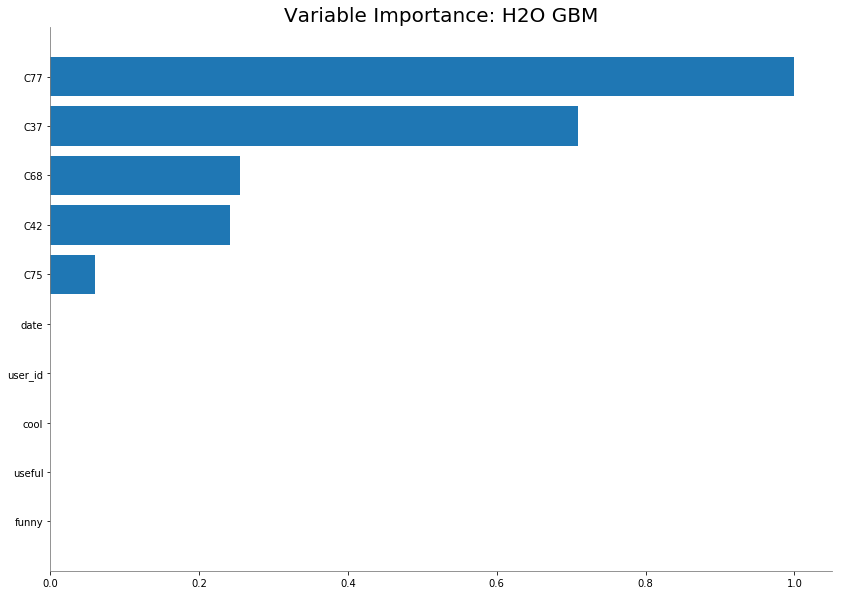

In [40]:
surrogate.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


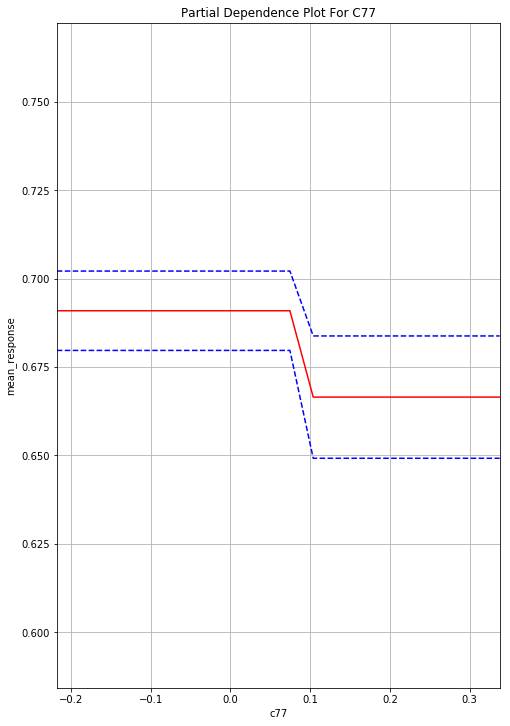

In [41]:
pdp_word_vecs = surrogate.partial_plot(data = ext_train, cols = ["C77"])

#### Individual Conditional Expectation (ICE)

In [58]:
ext_train_dice = h2o.H2OFrame(ext_train.as_data_frame().iloc[::30])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [60]:
C77_ice_df = ice(data=ext_train_dice, column='C77', model=surrogate)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


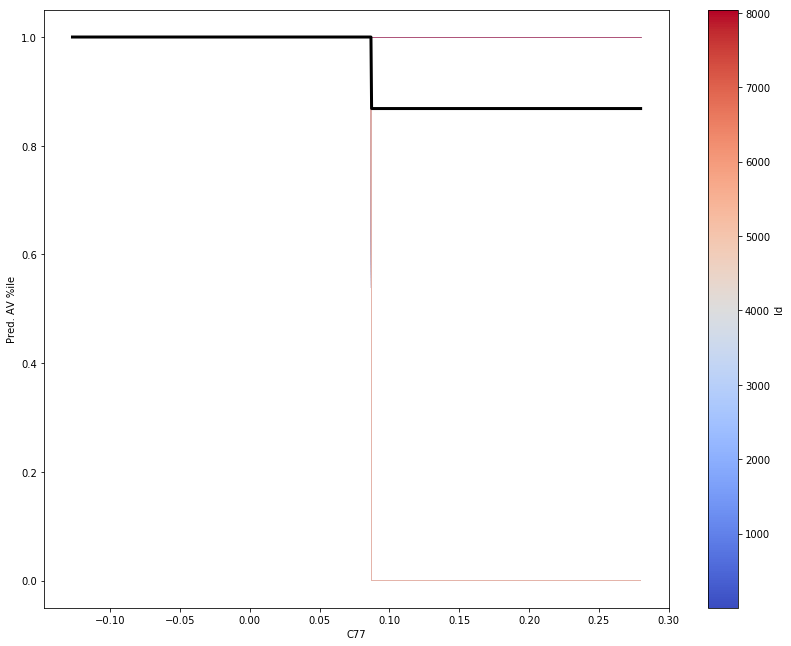

In [61]:
ice_plot(C77_ice_df, linewidth=0.5, color_by='Id', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C77_ice_df.columns.get_level_values('Id').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Id')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C77');

### 2.3.3 Matrix

In [43]:
print(surrogate)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.21083847996491153
RMSE: 0.45917151475773355
LogLoss: 0.6113959663662526
Mean Per-Class Error: 0.30551375837037864
AUC: 0.7475232119745653
pr_auc: 0.5517806090318984
Gini: 0.49504642394913057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6563125396395844: 


,0,1,Error,Rate
0,998.0,1602.0,0.6162,(1602.0/2600.0)
1,504.0,4964.0,0.0922,(504.0/5468.0)
Total,1502.0,6566.0,0.261,(2106.0/8068.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6563125,0.8249958,6.0
max f2,0.6426143,0.9131597,7.0
max f0point5,0.6739827,0.8002268,4.0
max accuracy,0.6678134,0.7424393,5.0
max precision,0.6993376,0.8977733,0.0
max recall,0.6426143,1.0,7.0
max specificity,0.6993376,0.9223077,0.0
max absolute_mcc,0.6739827,0.3800714,4.0
max min_per_class_accuracy,0.6847630,0.6376923,3.0
max mean_per_class_accuracy,0.6847630,0.6944862,3.0


Gains/Lift Table: Avg response rate: 67.77 %, avg score: 67.74 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2449182,0.6993376,1.3246589,1.3246589,0.8977733,0.6993376,0.8977733,0.6993376,0.3244331,0.3244331,32.4658891,32.4658891
,2,0.3242439,0.6878483,1.1504241,1.2820326,0.7796875,0.6878483,0.8688838,0.6965268,0.0912582,0.4156913,15.0424058,28.2032632
,3,0.6259296,0.6847630,1.1123792,1.2002631,0.7539030,0.6853071,0.8134653,0.6911191,0.3355889,0.7512802,11.2379248,20.0263061
,4,0.7612791,0.6678134,0.8890796,1.1449371,0.6025641,0.6701692,0.7759687,0.6873944,0.1203365,0.8716167,-11.0920413,14.4937051
,5,0.8138324,0.6563125,0.6890278,1.1154967,0.4669811,0.6563125,0.7560158,0.6853873,0.0362107,0.9078274,-31.0972243,11.5496670
,6,1.0,0.6426143,0.4951058,1.0,0.3355526,0.6426143,0.6777392,0.6774243,0.0921726,1.0,-50.4894230,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-26 13:01:22,0.040 sec,0.0,0.4673422,0.6285618,0.5,0.0,1.0,0.3222608
,2019-04-26 13:01:23,0.270 sec,1.0,0.4591715,0.6113960,0.7475232,0.5517806,1.3246589,0.2610312


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C78,152.7242279,1.0,0.4794871
C39,78.1902924,0.5119705,0.2454832
C76,53.5171318,0.3504168,0.1680203
C89,27.3431969,0.1790364,0.0858456
C41,6.7410007,0.0441384,0.0211638
---,---,---,---
C96,0.0,0.0,0.0
C97,0.0,0.0,0.0
C98,0.0,0.0,0.0
C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()



## 2.4 Gradient Boosting

### 2.4.1 Train & Fit Model

In [30]:
gbm = H2OGradientBoostingEstimator(stopping_metric = "AUC",
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10, 
                                           model_id = 'gbm.hex')
gbm.train(x = predictors, 
                   y = response,
                  training_frame = ext_train,
                  validation_frame = ext_test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [91]:
# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = gbm.download_mojo(path='data')

print(gbm)
print('Generated MOJO path:\n', mojo_path)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm.hex


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08931967158479732
RMSE: 0.29886396836152285
LogLoss: 0.3102821431820037
Mean Per-Class Error: 0.11260790051207015
AUC: 0.9562610432727477
pr_auc: 0.9764787387880995
Gini: 0.9125220865454955
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5696446528445371: 


,0,1,Error,Rate
0,2130.0,470.0,0.1808,(470.0/2600.0)
1,340.0,5128.0,0.0622,(340.0/5468.0)
Total,2470.0,5598.0,0.1004,(810.0/8068.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5696447,0.9268028,209.0
max f2,0.4300638,0.9532700,260.0
max f0point5,0.6619498,0.9317829,173.0
max accuracy,0.5696447,0.8996034,209.0
max precision,0.9812053,1.0,0.0
max recall,0.0451686,1.0,398.0
max specificity,0.9812053,1.0,0.0
max absolute_mcc,0.5696447,0.7676461,209.0
max min_per_class_accuracy,0.6539789,0.8867959,176.0
max mean_per_class_accuracy,0.6563273,0.8873921,175.0


Gains/Lift Table: Avg response rate: 67.77 %, avg score: 67.74 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100397,0.9710622,1.4754938,1.4754938,1.0,0.9749312,1.0,0.9749312,0.0148135,0.0148135,47.5493782,47.5493782
,2,0.0200793,0.9665890,1.4754938,1.4754938,1.0,0.9685779,1.0,0.9717545,0.0148135,0.0296269,47.5493782,47.5493782
,3,0.0301190,0.9634133,1.4754938,1.4754938,1.0,0.9648435,1.0,0.9694508,0.0148135,0.0444404,47.5493782,47.5493782
,4,0.0400347,0.9602228,1.4754938,1.4754938,1.0,0.9618061,1.0,0.9675574,0.0146306,0.0590710,47.5493782,47.5493782
,5,0.0500744,0.9566330,1.4754938,1.4754938,1.0,0.9585565,1.0,0.9657528,0.0148135,0.0738844,47.5493782,47.5493782
,6,0.1000248,0.9426201,1.4754938,1.4754938,1.0,0.9494756,1.0,0.9576243,0.0737015,0.1475860,47.5493782,47.5493782
,7,0.1500992,0.9309371,1.4681894,1.4730570,0.9950495,0.9368658,0.9983485,0.9506991,0.0735187,0.2211046,46.8189357,47.3056963
,8,0.2000496,0.9181663,1.4608487,1.4700087,0.9900744,0.9246596,0.9962825,0.9441973,0.0729700,0.2940746,46.0848682,47.0008675
,9,0.3000744,0.8888696,1.4572101,1.4657425,0.9876084,0.9045015,0.9933912,0.9309653,0.1457571,0.4398317,45.7210092,46.5742481
,10,0.3999752,0.8472880,1.4352198,1.4581189,0.9727047,0.8694905,0.9882244,0.9156109,0.1433797,0.5832114,43.5219758,45.8118894




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.1391421627716336
RMSE: 0.37301764404868787
LogLoss: 0.4304746117959944
Mean Per-Class Error: 0.22521973668450967
AUC: 0.853525000230332
pr_auc: 0.9243414013296912
Gini: 0.7070500004606639
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35734143953952213: 


,0,1,Error,Rate
0,254.0,368.0,0.5916,(368.0/622.0)
1,56.0,1340.0,0.0401,(56.0/1396.0)
Total,310.0,1708.0,0.2101,(424.0/2018.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3573414,0.8634021,299.0
max f2,0.2707677,0.9288618,325.0
max f0point5,0.7246772,0.8606151,158.0
max accuracy,0.5371222,0.7958375,236.0
max precision,0.9812737,1.0,0.0
max recall,0.0910947,1.0,387.0
max specificity,0.9812737,1.0,0.0
max absolute_mcc,0.6567836,0.5204296,188.0
max min_per_class_accuracy,0.6998688,0.7693410,168.0
max mean_per_class_accuracy,0.7246772,0.7747803,158.0


Gains/Lift Table: Avg response rate: 69.18 %, avg score: 68.67 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0104063,0.9707909,1.4455587,1.4455587,1.0,0.9741431,1.0,0.9741431,0.0150430,0.0150430,44.5558739,44.5558739
,2,0.0203171,0.9662386,1.3732808,1.4103012,0.95,0.9688937,0.9756098,0.9715824,0.0136103,0.0286533,37.3280802,41.0301209
,3,0.0302279,0.9631920,1.4455587,1.4218611,1.0,0.9646218,0.9836066,0.9693002,0.0143266,0.0429799,44.5558739,42.1861055
,4,0.0401388,0.9604564,1.4455587,1.4277123,1.0,0.9619730,0.9876543,0.9674910,0.0143266,0.0573066,44.5558739,42.7712335
,5,0.0500496,0.9565430,1.4455587,1.4312463,1.0,0.9585820,0.9900990,0.9657269,0.0143266,0.0716332,44.5558739,43.1246276
,6,0.1000991,0.9429929,1.4455587,1.4384025,1.0,0.9501886,0.9950495,0.9579577,0.0723496,0.1439828,44.5558739,43.8402508
,7,0.1501487,0.9300946,1.3883089,1.4217046,0.9603960,0.9365200,0.9834983,0.9508118,0.0694842,0.2134670,38.8308888,42.1704635
,8,0.2001982,0.9155333,1.3739964,1.4097776,0.9504950,0.9231091,0.9752475,0.9438861,0.0687679,0.2822350,37.3996425,40.9777582
,9,0.3002973,0.8817181,1.3310590,1.3835381,0.9207921,0.8996882,0.9570957,0.9291535,0.1332378,0.4154728,33.1059037,38.3538067
,10,0.3999009,0.8353003,1.2873384,1.3595776,0.8905473,0.8604410,0.9405204,0.9120392,0.1282235,0.5436963,28.7338380,35.9577550



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-04-26 17:53:38,0.082 sec,0.0,0.4673422,0.6285618,0.5,0.0,1.0,0.3222608,0.4619737,0.6181283,0.5,0.0,1.0,0.3082260
,2019-04-26 17:53:40,1.307 sec,10.0,0.3917510,0.4801409,0.8832582,0.9345443,1.4754938,0.1774913,0.4052403,0.5037722,0.8251688,0.9087745,1.4455587,0.2239841
,2019-04-26 17:53:41,2.485 sec,20.0,0.3564140,0.4130835,0.9134588,0.9544897,1.4754938,0.1481160,0.3870605,0.4649728,0.8402343,0.9184697,1.4455587,0.2125867
,2019-04-26 17:53:42,3.454 sec,30.0,0.3336222,0.3704187,0.9308313,0.9640868,1.4754938,0.1341101,0.3797440,0.4470631,0.8468304,0.9217538,1.3767226,0.2115956
,2019-04-26 17:53:43,4.444 sec,40.0,0.3155239,0.3381612,0.9446261,0.9709304,1.4754938,0.1144026,0.3760943,0.4376262,0.8501495,0.9238651,1.4455587,0.2115956
,2019-04-26 17:53:44,5.585 sec,50.0,0.2988640,0.3102821,0.9562610,0.9764787,1.4754938,0.1003966,0.3730176,0.4304746,0.8535250,0.9243414,1.4455587,0.2101090


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C77,795.9478760,1.0,0.1489959
C37,452.4991150,0.5685035,0.0847047
C65,264.6298218,0.3324713,0.0495369
C75,257.5611572,0.3235905,0.0482137
C42,248.3355865,0.3119998,0.0464867
---,---,---,---
C46,2.6425276,0.0033200,0.0004947
C13,0.9694639,0.0012180,0.0001815
C39,0.0,0.0,0.0
C83,0.0,0.0,0.0



See the whole table with table.as_data_frame()

Generated MOJO path:
 /Users/mandy/Desktop/AI-Addin/notebook/data


## 2.4.2 Interpretability

#### Variable Importance

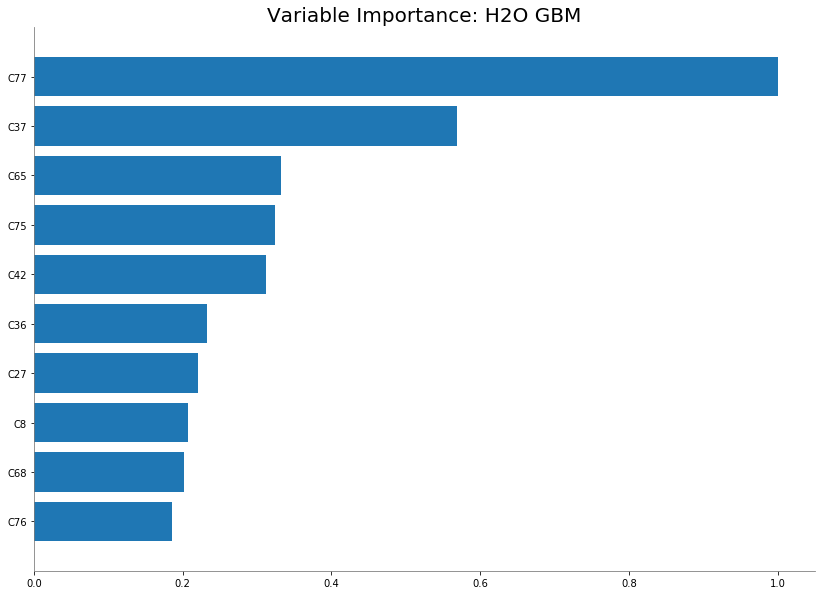

In [31]:
gbm.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


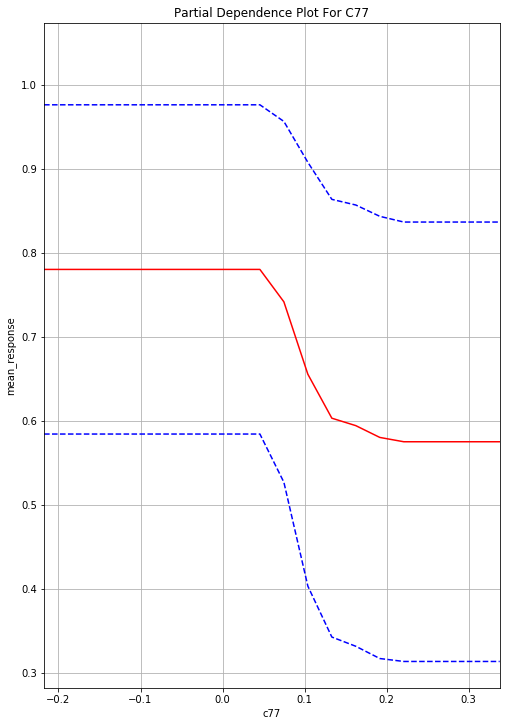

In [32]:
pdp_helpfulness = gbm.partial_plot(ext_train, cols = ['C77'])

#### Individual Conditional Expectation (ICE)

In [72]:
ext_train_gice = h2o.H2OFrame(ext_train.as_data_frame().iloc[::15])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [73]:
ext_train_gice.shape

(538, 111)

In [74]:
C77_ice_df = ice(data=ext_train_gice, column='C77', model=gbm)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


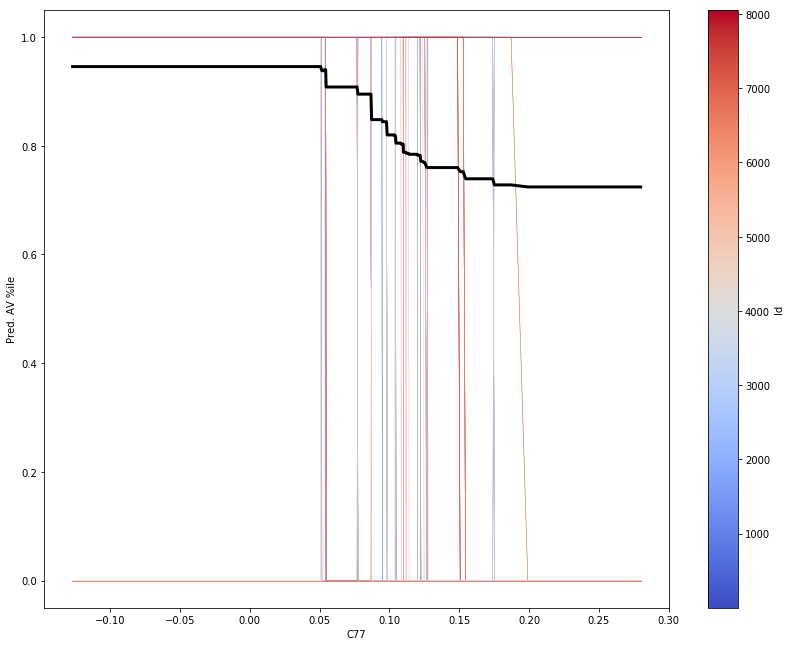

In [75]:
ice_plot(C77_ice_df, linewidth=0.5, color_by='Id', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C77_ice_df.columns.get_level_values('Id').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Id')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C77');

### 2.4.3 Matrix

In [76]:
print("AUC on validation data: " + str(round(gbm.auc(valid = True), 3)))

AUC on validation data: 0.854


In [77]:
gbm.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35734143953952213: 


,0,1,Error,Rate
0,254.0,368.0,0.5916,(368.0/622.0)
1,56.0,1340.0,0.0401,(56.0/1396.0)
Total,310.0,1708.0,0.2101,(424.0/2018.0)


In [78]:
gbm.r2(train=True, valid=True)

{'train': 0.5910435682943632, 'valid': 0.3474327558909355}

In [22]:
# h2o.cluster().shutdown()

H2O session _sid_970d closed.
